# 02_MARES_mooring_DATA_fromraw
Regrid raw MARES mooring data to hourly means, and convert some vraiables (T, Sp) to more useful forms (CT, Sa)

### Import packages

In [20]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

from metpy.calc import wind_components
from metpy.units import units

import gsw
import gsw.freezing

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import cmocean

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Open master 2017-2019 mooring data files
Different files for each year and mooring location. For each run, specify file name ("file") and years of the winter to grab data from (e.g. open_years = '2016_2017').

In [23]:
# M1
#--------------------------
# 2017-2019
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/raw/mares-mooring-m1-2017-2019_708f_9959_e0ad.csv'
# open_years = '2017_2018'
# open_years = '2018_2019'

# 2016-2017
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/raw/mares-mooring-m1_0786_46bf_f732.csv'
# open_years = '2016_2017'

# M2
#--------------------------
# 2017-2018
file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/raw/mares-mooring-m2-2017-2018_4de0_f9b1_cf0a.csv'
open_years = '2017_2018'

# 2016-2017
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M2/raw/mares-mooring-m2_cdf3_5fa4_3f35.csv'
# open_years = '2016_2017'

# M3
#--------------------------
# 2017-2018
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/raw/mares-mooring-m3-2017-2018_d596_5d0f_b4ec.csv'
# 2016-2017
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M3/raw/mares-mooring-m3_f38c_239a_cc5b.csv'

# M4
#--------------------------
# 2017-2018
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/raw/mares-mooring-m4-2017-2018_13a0_8681_05f5.csv'
# 2016-2017
# file = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M4/raw/mares-mooring-m4_d219_56a0_28df.csv'
# open_years = '2016_2017'

# determine which mooring
M = file.split('MARES_moorings/')[1].split('/')[0]
print(f'mooring {M}')

df = pd.read_csv(file,skiprows=[0])
UNITS  = df.columns.values
df = pd.read_csv(file,skiprows=[1])

# currents are every 20 minutes

cats = list(df.columns)
# units = list(df.columns)
for cat, unit in zip(cats, UNITS):
    print(f'{cat} [{unit}]')

pd_times = np.array([datetime.strptime(date, '%Y-%m-%dT%H:%M:%SZ') for date in df.time.values])
df['time'] = pd_times
# df.sea_water_speed

depths = np.sort(np.array(list(set(df.z.values))))


print(f"\ntime: {df['time'].values[0]} - {df['time'].values[-1]}")
print(f"\ndepths: {depths}")

mooring M2
time [UTC]
latitude [degrees_north]
longitude [degrees_east]
z [m]
sea_water_velocity_to_direction [degrees]
sea_water_velocity_to_direction_qc_agg [Unnamed: 5]
sea_water_speed [m.s-1]
sea_water_speed_qc_agg [Unnamed: 7]
sea_water_practical_salinity [1e-3]
sea_water_practical_salinity_qc_agg [Unnamed: 9]
eastward_sea_ice_velocity [m.s-1.1]
eastward_sea_ice_velocity_qc_agg [Unnamed: 11]
northward_sea_ice_velocity [m.s-1.2]
northward_sea_ice_velocity_qc_agg [Unnamed: 13]
sea_water_temperature [degree_Celsius]
sea_water_temperature_qc_agg [Unnamed: 15]

time: 2017-10-03T22:39:57.000000000 - 2018-10-11T00:38:44.000000000

depths: [-163. -162. -159. -155. -147. -143. -139. -135. -131. -127. -126. -123.
 -119. -115. -111. -109. -107. -103.  -99.  -95.  -91.  -87.  -83.  -79.
  -75.  -74.  -67.  -63.  -59.  -57.  -55.  -51.  -40.    0.]


# (A) Grab 60-minute sea ice velocity data

### (1) Find which current depths have many reported values (Depends on each variable)

In [24]:
current_depths = np.array([])

for depth in depths:
    
    var = 'eastward_sea_ice_velocity'
    
    if np.sum(np.isfinite(df[var][df.z == depth].values)) > 100:
        print(f'{depth}: # obs = {np.sum(np.isfinite(df[var][df.z == depth].values))}')
        current_depths = np.append(current_depths, depth)

0.0: # obs = 14362


### (2) Find hourly means

In [25]:
#==================================================
# sample_rate = 1200 # seconds for 20-minute steps
# sample_rate = 1800 # seconds for 30-minute steps
sample_rate = 3600 # seconds for 60-minute steps
#==================================================

# dates every xx minutes
Y1 = int(open_years.split('_')[0])
Y2 = int(open_years.split('_')[1])
spec_dates = np.array(pd.date_range(datetime(Y1,10,1,0), datetime(Y2,10,1, 0), freq='S'))[::sample_rate]

interp = {}

for depth in current_depths:
    
    interp[depth] = {}
    interp[depth]['u'] = np.full(len(spec_dates), np.nan)
    interp[depth]['v'] = np.full(len(spec_dates), np.nan)
    interp[depth]['obs'] = np.full(len(spec_dates), np.nan)
    
    # grab currents and sea ice velocity
    U = df.eastward_sea_ice_velocity.values
    V = df.northward_sea_ice_velocity.values

    # grab all times
    times = df.time[df.z == depth].values
    u_vals = U[df.z == depth]
    v_vals = V[df.z == depth]
    
        
    for dd, date in enumerate(spec_dates):

        # time diff in units of xx-min increments
        tdiff_seconds = ((times - date) / np.timedelta64(1, 's'))
        tdiff = tdiff_seconds / sample_rate

        # find those within sample_rate seconds up to nearest time
        time_ind = np.where( (tdiff > -1) & (tdiff <= 0) )[0]

        if len(time_ind) > 0:
            interp[depth]['obs'][dd] = np.sum(np.isfinite(u_vals[time_ind]))
            interp[depth]['u'][dd] = np.nanmean(u_vals[time_ind])
            interp[depth]['v'][dd] = np.nanmean(v_vals[time_ind])
            

            
# REGRID THE DATA
#----------------
all_u = np.array([])
all_v = np.array([])

for depth in current_depths:
    all_u = np.append(all_u, interp[depth]['u'])
    all_v = np.append(all_v, interp[depth]['v'])
    
u_grid = np.reshape(all_u, (len(current_depths), len(spec_dates)))
v_grid = np.reshape(all_v, (len(current_depths), len(spec_dates)))

dates_grid, depth_grid = np.meshgrid(spec_dates, current_depths)


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_43503/2832201361.py:42: RuntimeWarning: Mean of empty slice
  interp[depth]['u'][dd] = np.nanmean(u_vals[time_ind])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_43503/2832201361.py:43: RuntimeWarning: Mean of empty slice
  interp[depth]['v'][dd] = np.nanmean(v_vals[time_ind])


### (3) Save to netCDF

In [26]:
ds = xr.Dataset({"u": (("depth", "time"), u_grid),
                 "v": (("depth", "time"), v_grid)},
                coords={"depth": current_depths,
                        "time": spec_dates},
               attrs = {'lat': df.latitude.values[0], 'lon':df.longitude.values[0]})

mainpath = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
filename = f"{M}/{M}_hourly_seaice_velocity_{open_years}.nc"
ds.to_netcdf(mainpath+filename)

# (B) Grab 60-minute current data

### (1) Find which current depths have many reported values (Depends on each variable)

In [27]:
current_depths = np.array([])

for depth in depths:
    
    if 'eastward_sea_water_velocity' in cats:
        var = 'eastward_sea_water_velocity'
    else:
        var = 'sea_water_speed'
    
    if np.sum(np.isfinite(df[var][df.z == depth].values)) > 100:
        print(f'{depth}: # obs = {np.sum(np.isfinite(df[var][df.z == depth].values))}')
        current_depths = np.append(current_depths, depth)


-163.0: # obs = 26789
-159.0: # obs = 26789
-155.0: # obs = 26789
-147.0: # obs = 26789
-143.0: # obs = 26789
-139.0: # obs = 26789
-135.0: # obs = 26787
-131.0: # obs = 26787
-127.0: # obs = 26785
-123.0: # obs = 26777
-119.0: # obs = 26764
-115.0: # obs = 26736
-111.0: # obs = 26712
-107.0: # obs = 26632
-103.0: # obs = 26462
-99.0: # obs = 26055
-95.0: # obs = 25197
-91.0: # obs = 24135
-87.0: # obs = 22820
-83.0: # obs = 21300
-79.0: # obs = 19729
-75.0: # obs = 18136
-67.0: # obs = 15176
-63.0: # obs = 13946
-59.0: # obs = 13155
-55.0: # obs = 12392
-51.0: # obs = 11339


### (2) Find hourly means

In [28]:
#==================================================
# sample_rate = 1200 # seconds for 20-minute steps
# sample_rate = 1800 # seconds for 30-minute steps
sample_rate = 3600 # seconds for 60-minute steps
#==================================================

# dates every xx minutes
Y1 = int(open_years.split('_')[0])
Y2 = int(open_years.split('_')[1])
spec_dates = np.array(pd.date_range(datetime(Y1,10,1,0), datetime(Y2,10,1, 0), freq='S'))[::sample_rate]

interp = {}

for depth in current_depths:
    
    interp[depth] = {}
    interp[depth]['u'] = np.full(len(spec_dates), np.nan)
    interp[depth]['v'] = np.full(len(spec_dates), np.nan)
    interp[depth]['obs'] = np.full(len(spec_dates), np.nan)
    
    # grab currents and sea ice velocity

    if 'eastward_sea_water_velocity' in cats:
        
        # no need to convert for others
        #-----------------------------------
        U = df.eastward_sea_water_velocity.values
        V = df.northward_sea_water_velocity.values
        
    else:
        # need to convert for some years, moorings
        #--------------------------------
        # direction indicates the direction towards which the velocity vector of X is headed. 
        # The direction is a bearing in the usual geographical sense, measured positive clockwise from due north.
        directions = df.sea_water_velocity_to_direction.values
        speeds = df.sea_water_speed.values

        # transform from bearing to x - eastward and y - northward
        (u, v) = wind_components(speeds * units('m/s'), directions * units.deg)
        U = -u.magnitude
        V = -v.magnitude


    # grab all times
    times = df.time[df.z == depth].values
    u_vals = U[df.z == depth]
    v_vals = V[df.z == depth]
    
    for dd, date in enumerate(spec_dates):

        # time diff in units of xx-min increments
        tdiff_seconds = ((times - date) / np.timedelta64(1, 's'))
        tdiff = tdiff_seconds / sample_rate

        # find those within sample_rate seconds up to nearest time
        time_ind = np.where( (tdiff > -1) & (tdiff <= 0) )[0]

        if len(time_ind) > 0:
            interp[depth]['obs'][dd] = np.sum(np.isfinite(u_vals[time_ind]))
            interp[depth]['u'][dd] = np.nanmean(u_vals[time_ind])
            interp[depth]['v'][dd] = np.nanmean(v_vals[time_ind])
            
# REGRID THE DATA
#----------------
all_u = np.array([])
all_v = np.array([])

for depth in current_depths:
    all_u = np.append(all_u, interp[depth]['u'])
    all_v = np.append(all_v, interp[depth]['v'])
    
u_grid = np.reshape(all_u, (len(current_depths), len(spec_dates)))
v_grid = np.reshape(all_v, (len(current_depths), len(spec_dates)))

dates_grid, depth_grid = np.meshgrid(spec_dates, current_depths)


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_43503/3721732776.py:60: RuntimeWarning: Mean of empty slice
  interp[depth]['u'][dd] = np.nanmean(u_vals[time_ind])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_43503/3721732776.py:61: RuntimeWarning: Mean of empty slice
  interp[depth]['v'][dd] = np.nanmean(v_vals[time_ind])


### (3) Save to netCDF

In [29]:
ds = xr.Dataset({"u": (("depth", "time"), u_grid),
                 "v": (("depth", "time"), v_grid)},
                coords={"depth": current_depths,
                        "time": spec_dates},
               attrs = {'lat': df.latitude.values[0], 'lon':df.longitude.values[0]})

mainpath = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
filename = f"{M}/{M}_hourly_ocean_currents_{open_years}.nc"
ds.to_netcdf(mainpath+filename)


# (C) Grab 60-minute Temperature, Salinity data

### (1) Find which current depths have many reported values (Depends on each variable)

In [30]:
current_depths = np.array([])

for depth in depths:
    
    var = 'sea_water_temperature'
    
    if np.sum(np.isfinite(df[var][df.z == depth].values)) > 100:
        print(f'{depth}: # obs = {np.sum(np.isfinite(df[var][df.z == depth].values))}')
        current_depths = np.append(current_depths, depth)

-162.0: # obs = 35718
-143.0: # obs = 11905
-126.0: # obs = 107160
-109.0: # obs = 107160
-91.0: # obs = 107160
-74.0: # obs = 107090
-57.0: # obs = 107161
-40.0: # obs = 35718


### (2) Find hourly means

In [31]:
#==================================================
# sample_rate = 1200 # seconds for 20-minute steps
# sample_rate = 1800 # seconds for 30-minute steps
sample_rate = 3600 # seconds for 60-minute steps
#==================================================

# dates every xx minutes
Y1 = int(open_years.split('_')[0])
Y2 = int(open_years.split('_')[1])
spec_dates = np.array(pd.date_range(datetime(Y1,10,1,0), datetime(Y2,10,1, 0), freq='S'))[::sample_rate]

interp = {}

for depth in current_depths:
    
    interp[depth] = {}
    interp[depth]['T'] = np.full(len(spec_dates), np.nan)
    interp[depth]['S'] = np.full(len(spec_dates), np.nan)
    interp[depth]['obs'] = np.full(len(spec_dates), np.nan)
    
    # grab temperature and salinity
    T = df.sea_water_temperature.values
    S = df.sea_water_practical_salinity.values

    # grab all times
    times = df.time[df.z == depth].values
    T_vals = T[df.z == depth]
    S_vals = S[df.z == depth]
    
        
    for dd, date in enumerate(spec_dates):

        # time diff in units of xx-min increments
        tdiff_seconds = ((times - date) / np.timedelta64(1, 's'))
        tdiff = tdiff_seconds / sample_rate

        # find those within sample_rate seconds up to nearest time
        time_ind = np.where( (tdiff > -1) & (tdiff <= 0) )[0]
        
        if len(time_ind) > 0:
            interp[depth]['obs'][dd] = np.sum(np.isfinite(T_vals[time_ind]))
            interp[depth]['T'][dd] = np.nanmean(T_vals[time_ind])
            interp[depth]['S'][dd] = np.nanmean(S_vals[time_ind])
            
            
# REGRID THE DATA
#----------------
all_T = np.array([])
all_S = np.array([])

for depth in current_depths:
    all_T = np.append(all_T, interp[depth]['T'])
    all_S = np.append(all_S, interp[depth]['S'])
    
T_grid = np.reshape(all_T, (len(current_depths), len(spec_dates)))
S_grid = np.reshape(all_S, (len(current_depths), len(spec_dates)))

dates_grid, depth_grid = np.meshgrid(spec_dates, current_depths)


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_43503/1749358602.py:42: RuntimeWarning: Mean of empty slice
  interp[depth]['T'][dd] = np.nanmean(T_vals[time_ind])
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_43503/1749358602.py:43: RuntimeWarning: Mean of empty slice
  interp[depth]['S'][dd] = np.nanmean(S_vals[time_ind])


### (3) Convert T, S to more useful forms

In [32]:


# grab coordinates
lat = df.latitude.values[0]
lon = df.longitude.values[0]

def calc_vars_from_T_S(T, SP, depth, lon, lat, saturation_fraction = 1):
    
    # sea pressure ( i.e. absolute pressure - 10.1325 dbar )
    p = gsw.conversions.p_from_z(depth, lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)

    # Absolute Salinity (g / kg)
    SA = gsw.conversions.SA_from_SP(SP, p, lon, lat)

    # Conservative Temperature (ITS-90) (degC)
    CT = gsw.conversions.CT_from_t(SA, T, p)

    # Saturation fraction of dissolved air in seawater. (0..1)
    # let's assume its 1?
#     saturation_fraction = 1
    
    # freezing point of water
    T_f = gsw.freezing.CT_freezing(SA, p, saturation_fraction)

    # potential density
    sigma0 = gsw.density.sigma1(SA, CT)
    
    return SA, CT, sigma0, T_f, p


Sa, Ct, r0, Tf, p = calc_vars_from_T_S(T_grid, S_grid, depth_grid, lon, lat, saturation_fraction = 1)


# stability
N2_, pmid_ = gsw.stability.Nsquared(Sa[::-1,:], Ct[::-1,:], p[::-1,:], lat=lat, axis=0)
N2 = N2_[::-1, :]
pmid = pmid_[::-1, :]

<IPython.core.display.Javascript object>


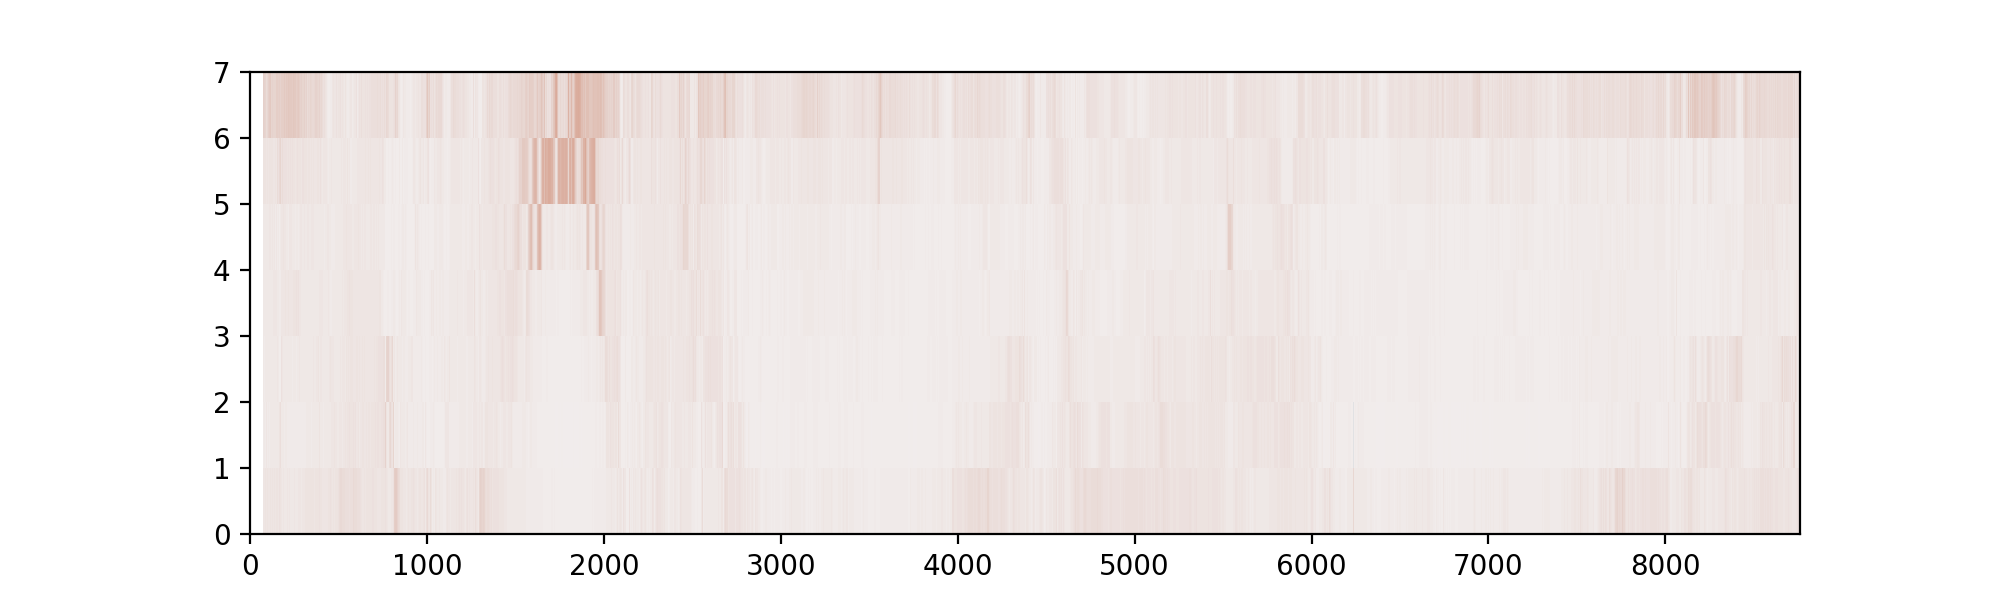

In [33]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,3))
plt.pcolormesh(N2, vmin=-0.005, vmax = 0.005, cmap=cmocean.cm.balance)

### (4) Save to netCDF

In [34]:
ds = xr.Dataset({"T": (("depth", "time"), T_grid, {'long_name':'temperature', 'units':'degC'}),
                 "Sp": (("depth", "time"), S_grid, {'long_name':'Practical salinity', 'units':'psu'}),
                 "Sa": (("depth", "time"), Sa, {'long_name':'Absolute salinity','units':'g/kg'}),
                 "Ct": (("depth", "time"), Ct, {'long_name':'Conservative temperature','units':'degC'}),
                 "Tf": (("depth", "time"), Tf, {'long_name':'Freezing temperature','units':'degC'}),
                  "sig0": (("depth", "time"), r0, {'long_name':'Potential density anomaly (pd minus 1000 kg/m^3)','units':'kg/m^3'}),
                },
                coords={"depth": current_depths,
                        "time": spec_dates},
               attrs = {'lat': df.latitude.values[0], 'lon':df.longitude.values[0]})


# ds = xr.Dataset({"T": (("depth", "time"), T_grid),
#                  "S": (("depth", "time"), S_grid)},
#                 coords={"depth": current_depths,
#                         "time": spec_dates},
#                attrs = {'lat': df.latitude.values[0], 'lon':df.longitude.values[0]})

mainpath = '/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/'
filename = f"{M}/{M}_hourly_tempsalinity_{open_years}.nc"
ds.to_netcdf(mainpath+filename)